In [1]:
from lib.header_notebook import *
import lib.OTCommon as OTCommon
import lib.SinkhornNP as Sinkhorn
import lib.LinHK as LinHK
import lib.LinW2 as LinW2
import lib.Tools as Tools

%matplotlib inline

# Visualize all samples to get an idea of dataset
* have variation in elongation and relative mass of ellipses
* size varation is relatively subtle

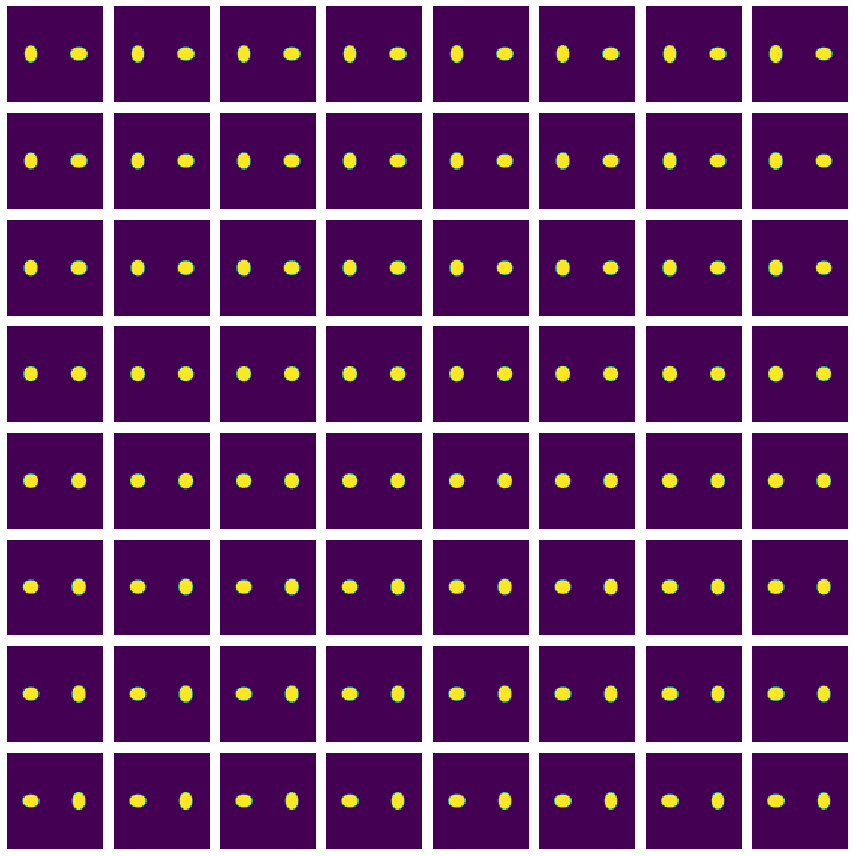

In [2]:
fig=plt.figure(figsize=(12,12))
for i in range(64):
    filename="data/two_ellipses_rad0d25/sample_{:03d}.mat".format(i)
    datSamp=OTCommon.importMeasure(filename,totalMass=1.,keepZero=False)
    fig.add_subplot(8,8,i+1)
    plt.imshow(datSamp[0])
    plt.axis("off")
plt.tight_layout()
plt.show()


# Principal component analysis in tangent space: W and HK

In [3]:
# load reference measure, here we just take Euclidean mean
datRef=OTCommon.importMeasure("data/two_ellipses_rad0d25/mean.mat",totalMass=1.,keepZero=False)
muRef=datRef[1]
posRef=datRef[2].astype(np.double)
res=datRef[3]

In [4]:
params={}
params["setup_HKScale"]=5

In [5]:
import pickle
with open("experiments/two_ellipses_rad0d25_W/tangent.dat", 'rb') as f:
    tangentListW,distListW=pickle.load(f)

with open("experiments/two_ellipses_rad0d25_HK5/tangent.dat", 'rb') as f:
    tangentListHK,distListHK=pickle.load(f)

In [6]:
# data matrix W:
dataMatrixW=LinW2.buildDataMatrix(tangentListW,muRef)
# center data matrix
linMeanW=np.mean(dataMatrixW,axis=0)
dataMatrixW=dataMatrixW-linMeanW

# check if shape makes sense:
# 64 samples
# reference measure: 244 pts
# on each point have dim=2 velocity components
# so get 2*244=488
dataMatrixW.shape

(64, 488)

In [7]:
# data matrix HK:
dataMatrixHK=LinHK.buildDataMatrix(tangentListHK,muRef,HKScale=params["setup_HKScale"])
# center data matrix
linMeanHK=np.mean(dataMatrixHK,axis=0)
dataMatrixHK=dataMatrixHK-linMeanHK

# check if shape makes sense:
# 64 samples
# reference measure: 244 pts
# on each point have dim=2 velocity components + 1 growth field component
# so get 3*244=732
dataMatrixHK.shape

(64, 732)

In [8]:
eigvalW,eigvecW=Tools.PCA(dataMatrixW)
eigvalHK,eigvecHK=Tools.PCA(dataMatrixHK)

In [9]:
# coordinates of samples in PCA bases
coefW=np.einsum(eigvecW,[0,1],dataMatrixW,[2,1],[2,0])
coefHK=np.einsum(eigvecHK,[0,1],dataMatrixHK,[2,1],[2,0])

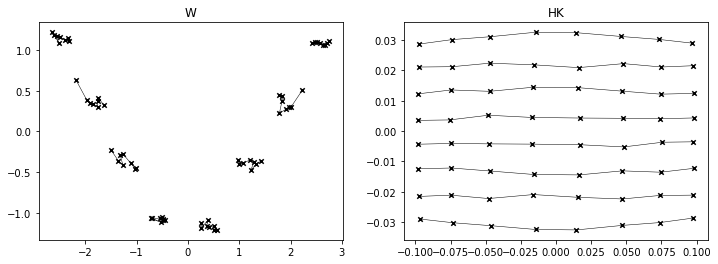

In [10]:
# show coordinates in PCA basis, first two modes
# connect samples with same elongation parameter, but different mass params with a line
fig=plt.figure(figsize=(12,4))

fig.add_subplot(1,2,1)
plt.title("W")
for i in range(8):
    plt.plot(coefW[i::8,0],coefW[i::8,1],c="k",lw=0.5)
plt.scatter(coefW[:,0],coefW[:,1],c="k",s=20,marker="x")

fig.add_subplot(1,2,2)
plt.title("HK")
for i in range(8):
    plt.plot(coefHK[i::8,0],coefHK[i::8,1],c="k",lw=0.5)
plt.scatter(coefHK[:,0],coefHK[:,1],c="k",s=20,marker="x")

plt.show()
# comment: W plot shown in paper may look slightly different, because:
# -it was produced with LinHK numerics, simply with very high value for HKScale
# -a different reference measure was used

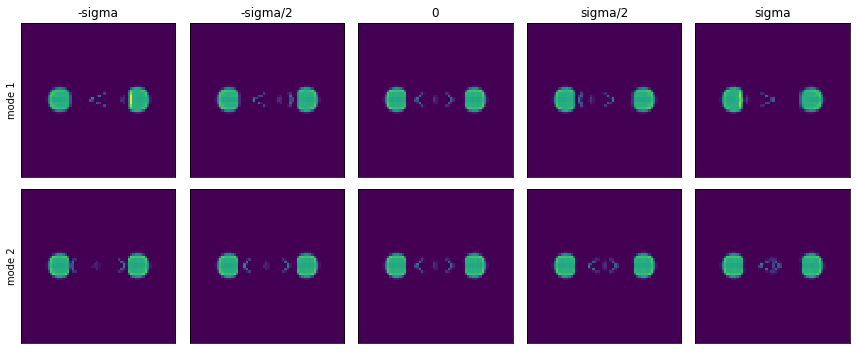

In [11]:
# shoot along eigenmodes of W embedding
fig=plt.figure(figsize=(12,5))
titleList=["-sigma","-sigma/2","0","sigma/2","sigma"]

vecMean=LinW2.decomposeEigenvectors([linMeanW],muRef)[0]
imgListList=[]
# generate all images in advance
for i in range(2):
    imgList=[]
    # how to shoot? take sqrt of corresponding eigenvalue
    scale=1*eigvalW[i]**0.5
    # how many pictures
    nPic=5
    # "unflatten" eigenvector
    vec=LinW2.decomposeEigenvectors([eigvecW[i]],muRef)[0]
    

    for j,scale in enumerate(np.linspace(-scale,scale,nPic)):

        muExp=muRef.copy()
        TExp=posRef+vecMean+scale*vec
        img=Tools.rasterizePointCloud(muExp,TExp,res)
        imgList.append(img)
    imgListList.append(imgList)
imgListList=np.array(imgListList)
imgListList/=np.max(imgListList)

# now plot / save to file
for i,imgList in enumerate(imgListList):
    # how many pictures
    nPic=5

    for j,img in enumerate(imgList):
        fig.add_subplot(2,nPic,i*nPic+j+1)

        img=(cm.viridis(img)[:,:,:3]*255).astype(np.uint8)

        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        if i==0:
            plt.title(titleList[j])
        if j==0:
            plt.ylabel("mode {:d}".format(i+1))
plt.tight_layout()
plt.show()

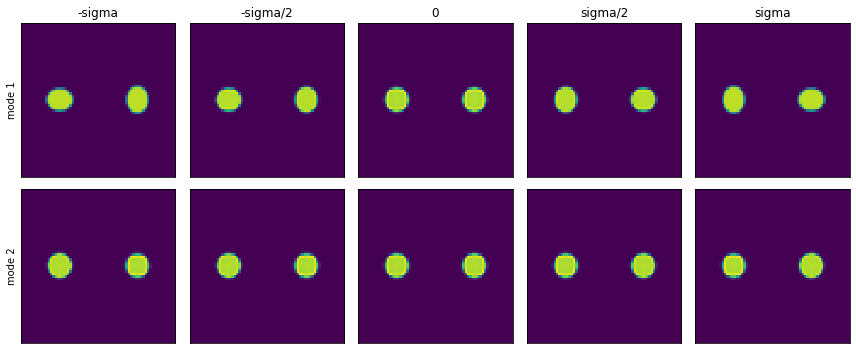

In [12]:
# shoot along eigenmodes of W embedding
fig=plt.figure(figsize=(12,5))
titleList=["-sigma","-sigma/2","0","sigma/2","sigma"]

velMean,alphaMean=LinHK.decomposeEigenvectors([linMeanHK],muRef,HKScale=params["setup_HKScale"])[0]
imgListList=[]
# generate all images in advance
for i in range(2):
    imgList=[]
    # how to shoot? take sqrt of corresponding eigenvalue
    scale=1*eigvalHK[i]**0.5
    # how many pictures
    nPic=5
    # "unflatten" eigenvector
    vel,alpha=LinHK.decomposeEigenvectors([eigvecHK[i]],muRef,HKScale=params["setup_HKScale"])[0]
    

    for j,scale in enumerate(np.linspace(-scale,scale,nPic)):

        muExp=muRef.copy()
        TExp=posRef+vecMean+scale*vec
        
        (muExp,TExp)=LinHK.HKExp(muRef,posRef,\
                velMean+vel*scale,alphaMean+alpha*scale,HKScale=params["setup_HKScale"])
        
        
        img=Tools.rasterizePointCloud(muExp,TExp,res)
        imgList.append(img)
    imgListList.append(imgList)
imgListList=np.array(imgListList)
imgListList/=np.max(imgListList)

# now plot / save to file
for i,imgList in enumerate(imgListList):
    # how many pictures
    nPic=5

    for j,img in enumerate(imgList):
        fig.add_subplot(2,nPic,i*nPic+j+1)

        img=(cm.viridis(img)[:,:,:3]*255).astype(np.uint8)

        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        if i==0:
            plt.title(titleList[j])
        if j==0:
            plt.ylabel("mode {:d}".format(i+1))
plt.tight_layout()
plt.show()

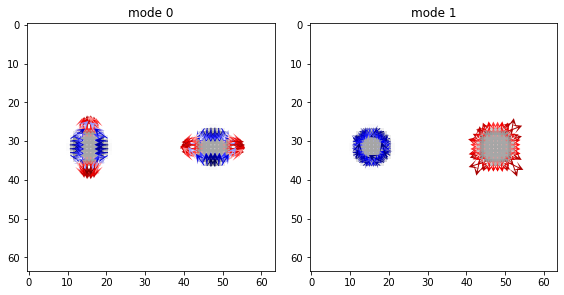

In [13]:
# quiver plot for HK mdes

# first, obtain linearized mean
velMean,alphaMean=LinHK.decomposeEigenvectors([linMeanHK],muRef,HKScale=params["setup_HKScale"])[0]
(muExp,TExp)=LinHK.HKExp(muRef,posRef,\
        velMean,alphaMean,HKScale=params["setup_HKScale"])
img=Tools.rasterizePointCloud(muExp,TExp,res)



#img=img.transpose((1,0))
img/=np.max(img)
img*=0.5
img=cm.Greys(img)

# extract tangent modes
alphaList=[]
velList=[]
for i in range(2):
    vel,alpha=LinHK.decomposeEigenvectors([eigvecHK[i]],muRef,HKScale=params["setup_HKScale"])[0]
    alphaList.append(alpha)
    velList.append(vel)

# normalize for colorization
alphaList=np.array(alphaList)
alphaList-=np.min(alphaList)
alphaList/=np.max(alphaList)
    
fig=plt.figure(figsize=(8,4))
for i in range(2):
    vel=velList[i]
    alpha=alphaList[i]
    
    colAlpha=cm.seismic(alpha)

    fig.add_subplot(1,2,i+1)
    plt.imshow(img)
    
    plt.quiver(TExp[:,1],TExp[:,0],vel[:,1],vel[:,0],color=colAlpha,angles="xy",units="xy",\
            scale=params["setup_HKScale"]/3,headwidth=10,headlength=10)

    #plt.axis("off")
    plt.title("mode {:d}".format(i))
    
plt.tight_layout()
plt.show()
